In [1]:
import sys
import tensorflow.keras 
import pandas as pd 
import sklearn as sk 
import tensorflow as tf 
import platform
print ( f"Python Platform: {platform.platform()}")
print (f"Tensor Flow Version: {tf.__version__} ")
print (f"Keras Version: {tensorflow.keras.__version__} ")
print ()
print (f"Python {sys.version}")
print (f"Pandas {pd.__version__}")
print (f"Scikit-Learn {sk.__version__}")
gpu = len(tf. config.list_physical_devices('GPU'))>0
print ("GPU is","available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.1-arm64-arm-64bit
Tensor Flow Version: 2.9.0 
Keras Version: 2.9.0 

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is available


In [2]:
# imports for running the project
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
# import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

Mounting the Git repository data

In [3]:
!git clone https://github.com/ttq693/CS711_team1.git

fatal: destination path 'CS711_team1' already exists and is not an empty directory.


Exploring the data !!

In [4]:
# We are reading the CSV file into the data Frame
train_df = pd.read_csv('CS711_team1/train_FD001.txt/train_FD001.txt',sep = " ",header = None)
test_df = pd.read_csv('CS711_team1/test_FD001.txt/test_FD001.txt',sep = " ",header = None)
y_test = pd.read_csv('CS711_team1/RUL_FD001.txt', sep="\s+", header=None)

In [5]:
train_df.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]

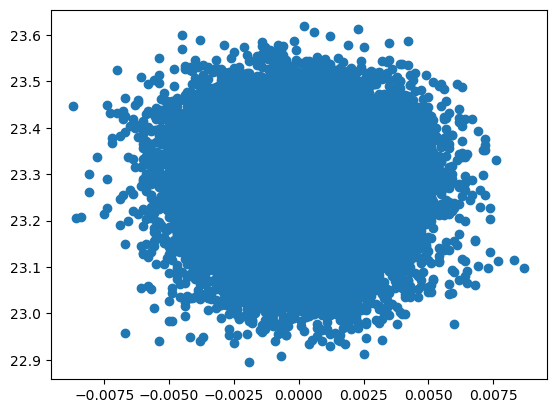

In [6]:
# Checking for outliers between 2 and 25
plt.scatter(train_df[2],train_df[25])

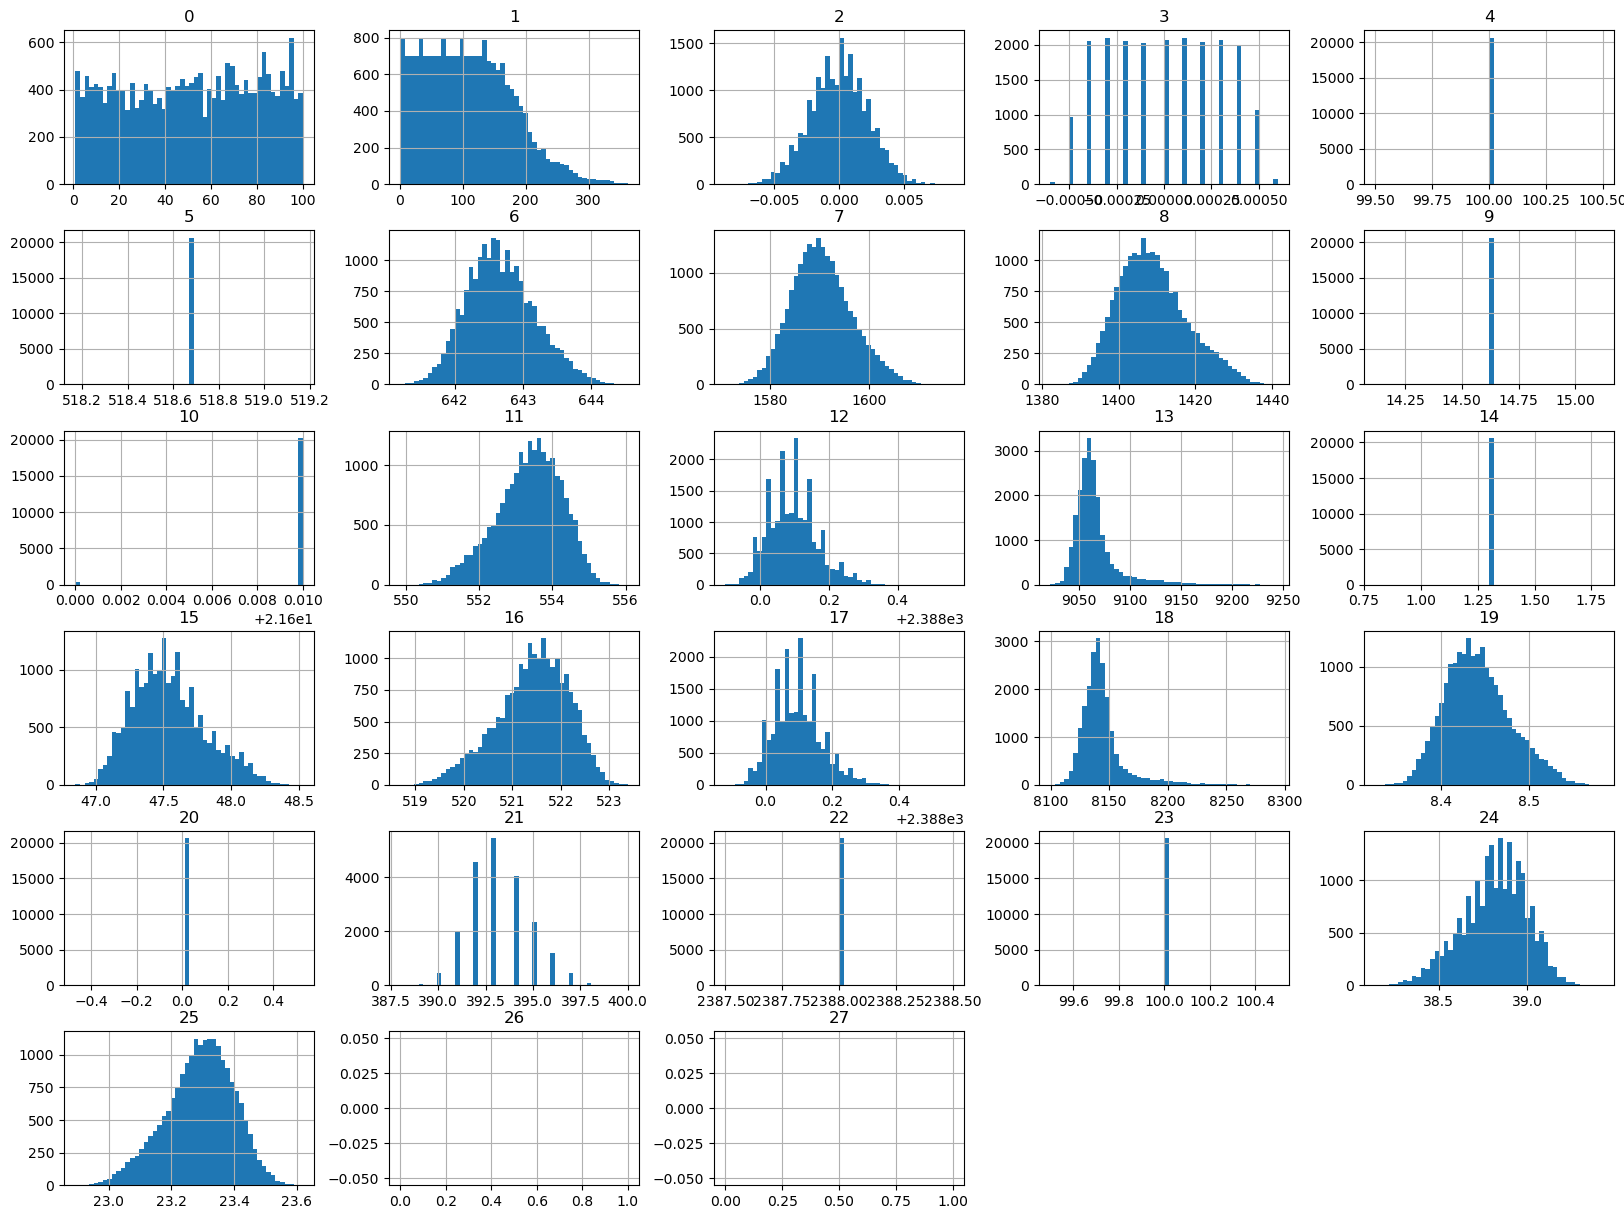

In [7]:
#	By visualizing graphs, we can identify the strongly and zero variance columns in the dataset
# Other insights regarding the changing pattern can also be observed by visualization

train_df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# We have dropped all the columns which were having NAN values
train_df=train_df.drop([26 , 27], axis = 1) 

In [9]:
# we have rename all the column name.
train_df.columns =['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [10]:
train_df.head()

unit  cycles  op_setting1  op_setting2  op_setting3      s1      s2  \
0     1       1      -0.0007      -0.0004        100.0  518.67  641.82   
1     1       2       0.0019      -0.0003        100.0  518.67  642.15   
2     1       3      -0.0043       0.0003        100.0  518.67  642.35   
3     1       4       0.0007       0.0000        100.0  518.67  642.35   
4     1       5      -0.0019      -0.0002        100.0  518.67  642.37   

        s3       s4     s5  ...     s12      s13      s14     s15   s16  s17  \
0  1589.70  1400.60  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392   
1  1591.82  1403.14  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392   
2  1587.99  1404.20  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390   
3  1582.79  1401.87  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392   
4  1582.85  1406.22  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393   

    s18    s19    s20      s21  
0  2388  100.0  39.06  23.4190  
1  2388  100.0  39.00  23.4236  
2  2388  100.0  38.95  23.3442  
3  2388  100.0  38.88  23.3739  
4  2388  100.0  38.90  23.4044  

[5 rows x 26 columns]

Preprocess the data

In [11]:
# we have first enter two column which name is unit  and cycles. and find max of cycles then max minus cycles.. 
def append_rul(df):
  rul = pd.DataFrame(df.groupby('unit')['cycles'].max()).reset_index()
  rul.columns = ['unit','max']
  df = df.merge(rul,on = 'unit',how = 'left')
  df['rul'] = df['max'] - df['cycles']
  df = df.drop(['max'],axis = 1)
  return df

train_df = append_rul(train_df)
train_df.head()

unit  cycles  op_setting1  op_setting2  op_setting3      s1      s2  \
0     1       1      -0.0007      -0.0004        100.0  518.67  641.82   
1     1       2       0.0019      -0.0003        100.0  518.67  642.15   
2     1       3      -0.0043       0.0003        100.0  518.67  642.35   
3     1       4       0.0007       0.0000        100.0  518.67  642.35   
4     1       5      -0.0019      -0.0002        100.0  518.67  642.37   

        s3       s4     s5  ...      s13      s14     s15   s16  s17   s18  \
0  1589.70  1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388   
1  1591.82  1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388   
2  1587.99  1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388   
3  1582.79  1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388   
4  1582.85  1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388   

     s19    s20      s21  rul  
0  100.0  39.06  23.4190  191  
1  100.0  39.00  23.4236  190  
2  100.0  38.95  23.3442  189  
3  100.0  38.88  23.3739  188  
4  100.0  38.90  23.4044  187  

[5 rows x 27 columns]

In [12]:
# We have dropped all the columns which were having NAN values from test_df data set
test_df=test_df.drop([26 , 27], axis = 1)

In [13]:
#we have rename all the column name from test_df data set
test_df.columns =['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [14]:
test_df.head()

unit  cycles  op_setting1  op_setting2  op_setting3      s1      s2  \
0     1       1       0.0023       0.0003        100.0  518.67  643.02   
1     1       2      -0.0027      -0.0003        100.0  518.67  641.71   
2     1       3       0.0003       0.0001        100.0  518.67  642.46   
3     1       4       0.0042       0.0000        100.0  518.67  642.44   
4     1       5       0.0014       0.0000        100.0  518.67  642.51   

        s3       s4     s5  ...     s12      s13      s14     s15   s16  s17  \
0  1585.29  1398.21  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392   
1  1588.45  1395.42  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393   
2  1586.94  1401.34  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393   
3  1584.12  1406.42  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391   
4  1587.19  1401.92  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390   

    s18    s19    s20      s21  
0  2388  100.0  38.86  23.3735  
1  2388  100.0  39.02  23.3916  
2  2388  100.0  39.08  23.4166  
3  2388  100.0  39.00  23.3737  
4  2388  100.0  38.99  23.4130  

[5 rows x 26 columns]

In [15]:
#we have call the function which use to make new rul column which use to find remaning useful life cycles from test_df data set
test_df = append_rul(test_df)

In [16]:
test_df.head()

unit  cycles  op_setting1  op_setting2  op_setting3      s1      s2  \
0     1       1       0.0023       0.0003        100.0  518.67  643.02   
1     1       2      -0.0027      -0.0003        100.0  518.67  641.71   
2     1       3       0.0003       0.0001        100.0  518.67  642.46   
3     1       4       0.0042       0.0000        100.0  518.67  642.44   
4     1       5       0.0014       0.0000        100.0  518.67  642.51   

        s3       s4     s5  ...      s13      s14     s15   s16  s17   s18  \
0  1585.29  1398.21  14.62  ...  2388.03  8125.55  8.4052  0.03  392  2388   
1  1588.45  1395.42  14.62  ...  2388.06  8139.62  8.3803  0.03  393  2388   
2  1586.94  1401.34  14.62  ...  2388.03  8130.10  8.4441  0.03  393  2388   
3  1584.12  1406.42  14.62  ...  2388.05  8132.90  8.3917  0.03  391  2388   
4  1587.19  1401.92  14.62  ...  2388.03  8129.54  8.4031  0.03  390  2388   

     s19    s20      s21  rul  
0  100.0  38.86  23.3735   30  
1  100.0  39.02  23.3916   29  
2  100.0  39.08  23.4166   28  
3  100.0  39.00  23.3737   27  
4  100.0  38.99  23.4130   26  

[5 rows x 27 columns]

plotting the histogram

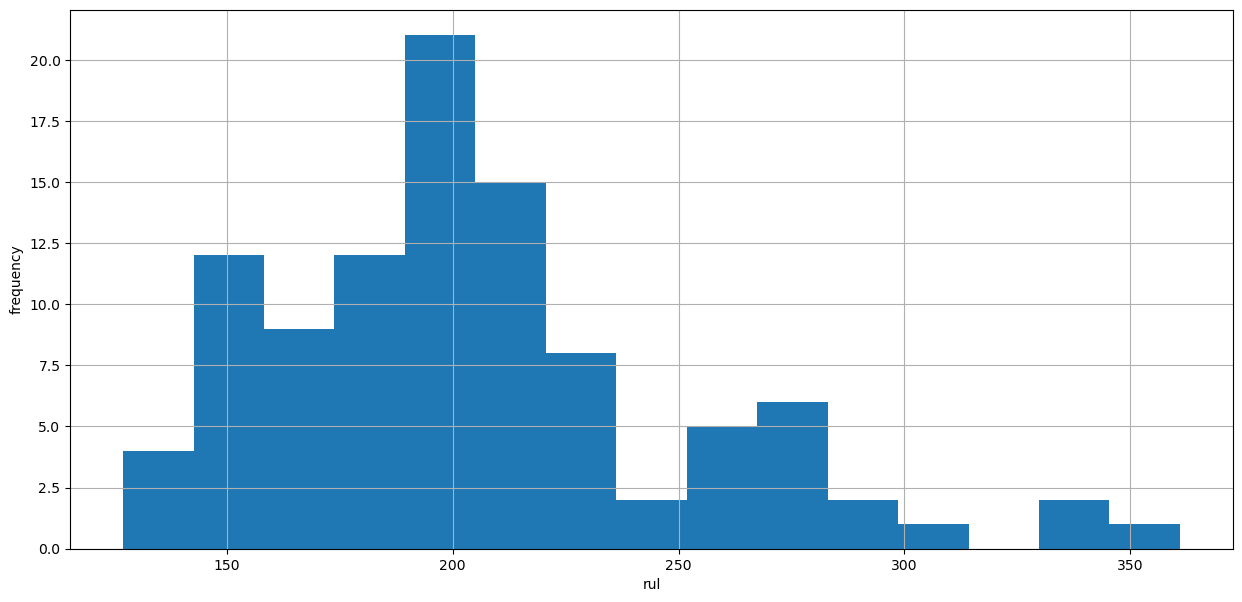

In [17]:
df_max_rul = train_df[['unit', 'rul']].groupby('unit').max().reset_index()
df_max_rul['rul'].hist(bins=15, figsize=(15,7))
plt.xlabel('rul')
plt.ylabel('frequency')
plt.show()

plot signals of each sensor

In [18]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train_df['unit'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('rul', sensor_name, 
                     data=train_df[train_df['unit']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

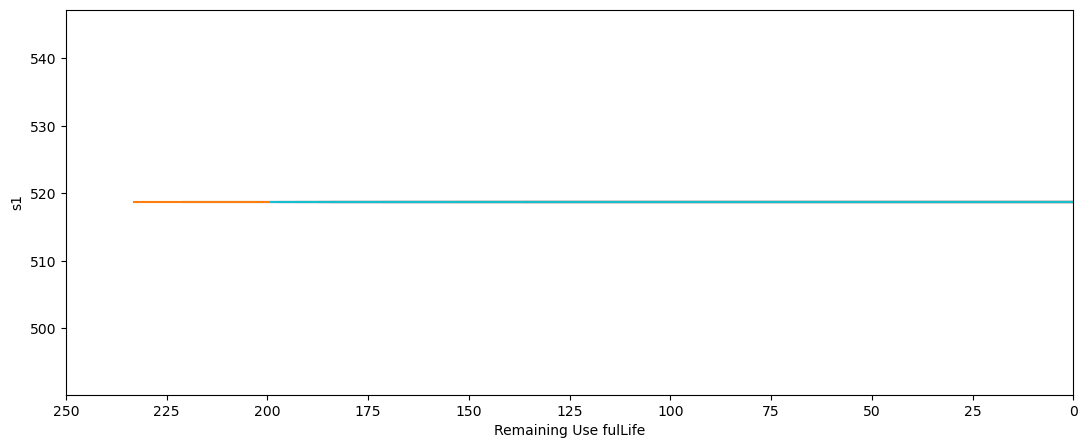

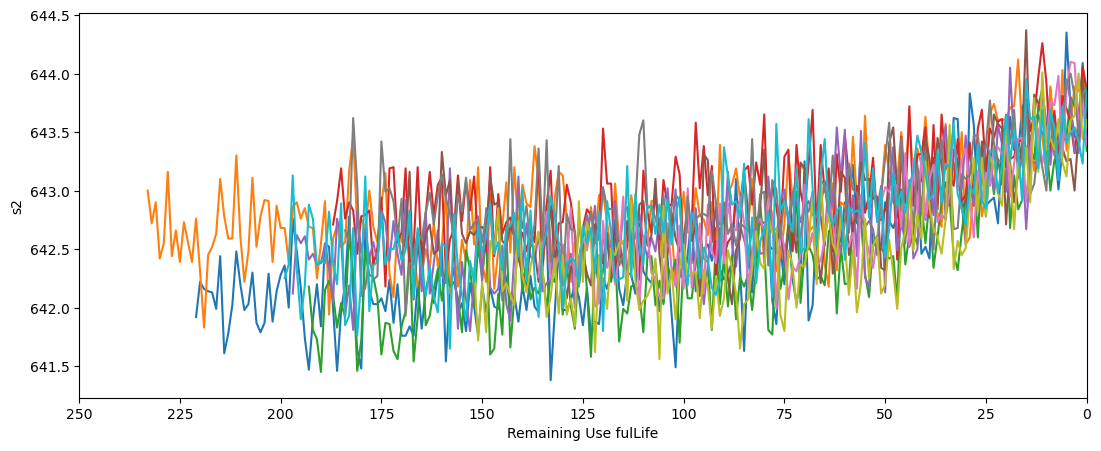

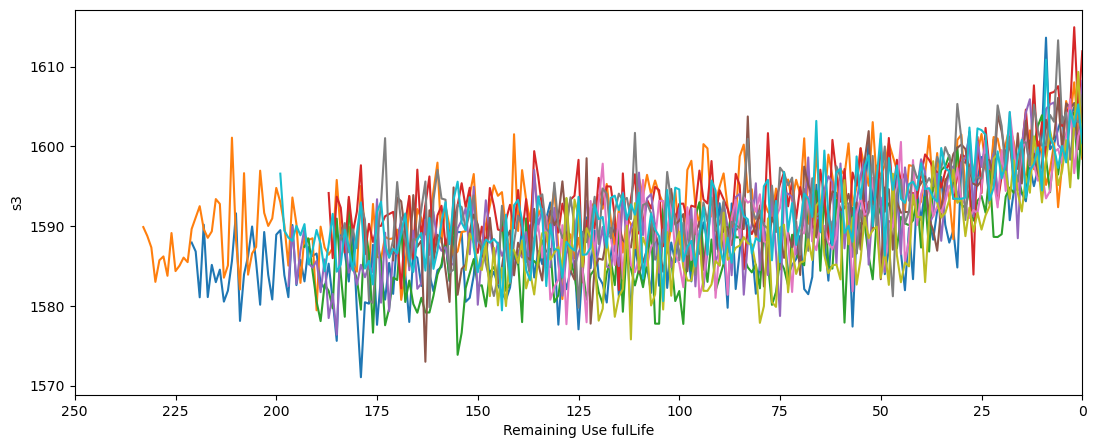

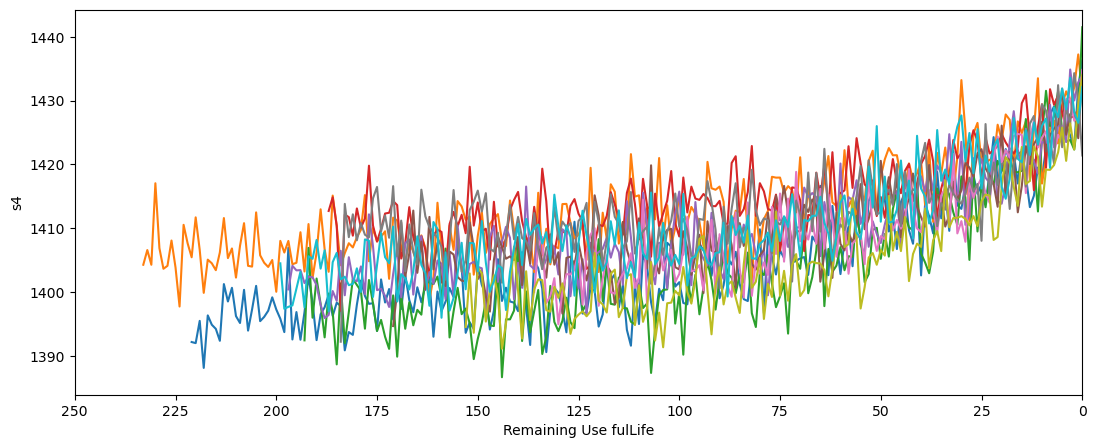

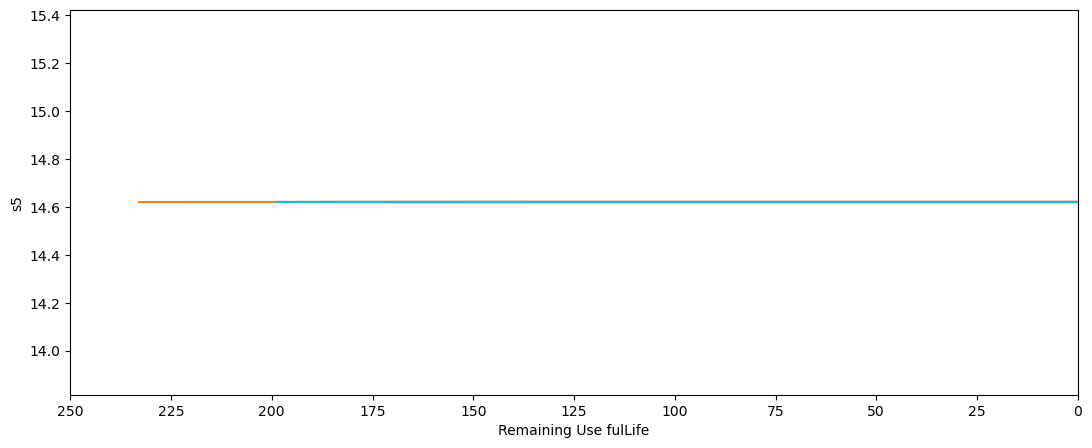

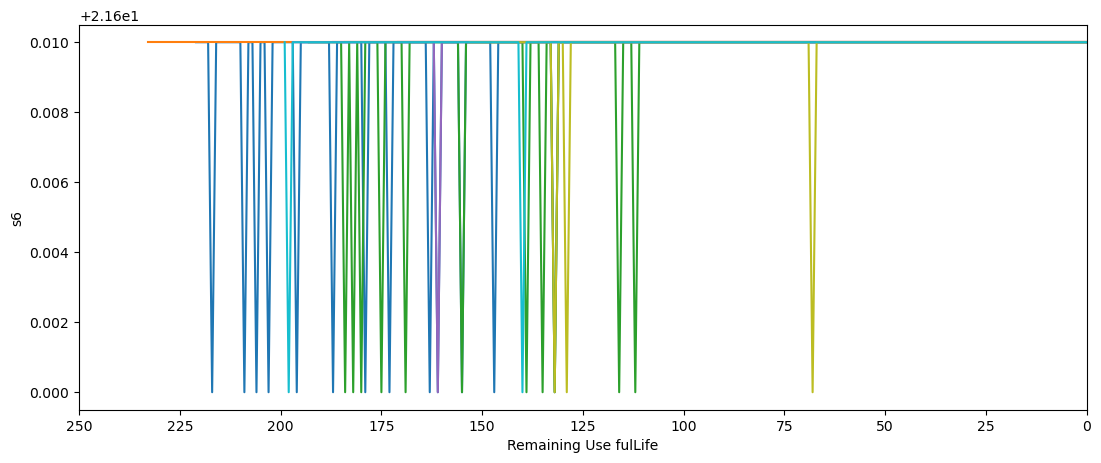

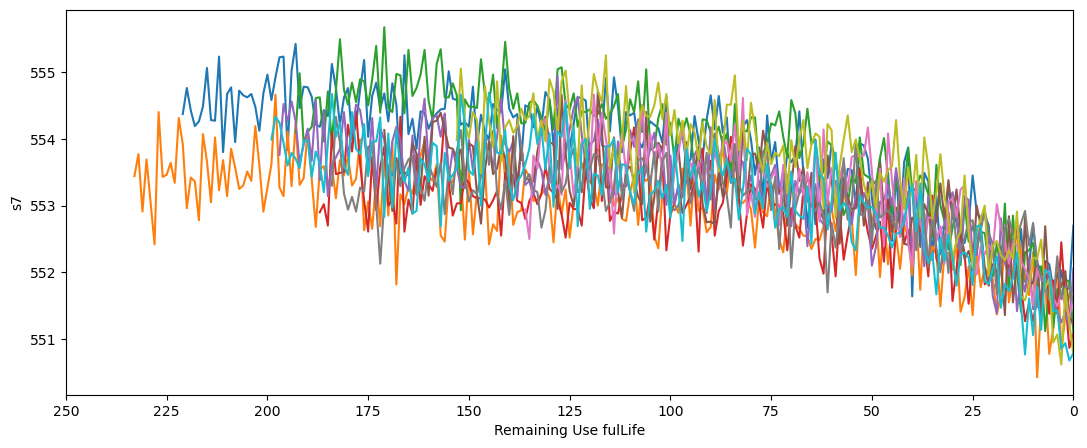

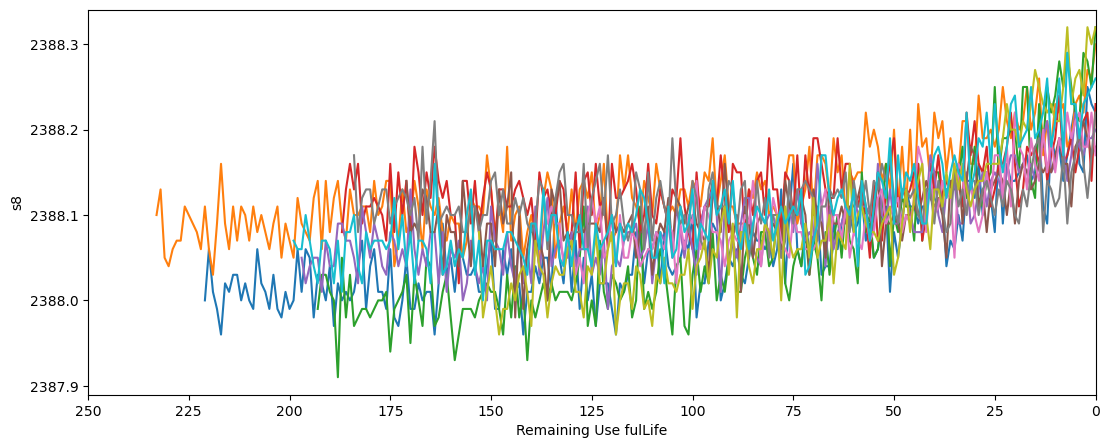

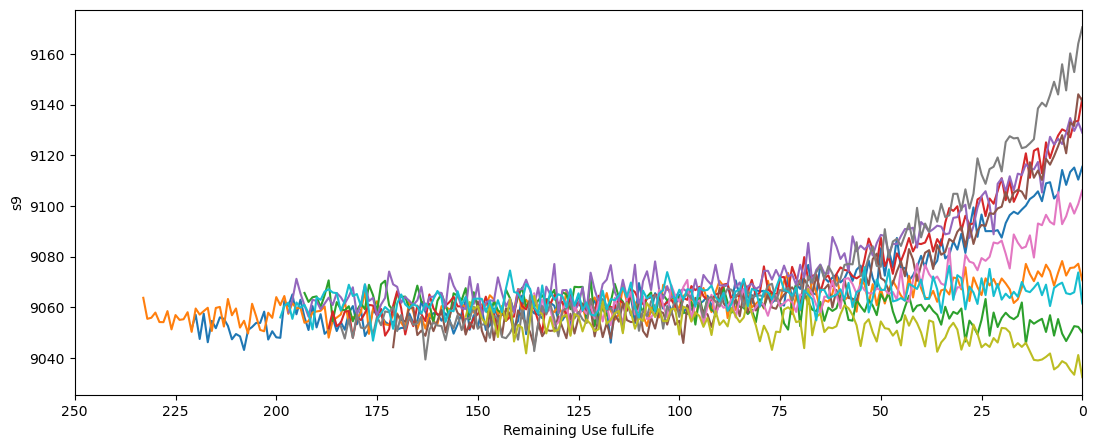

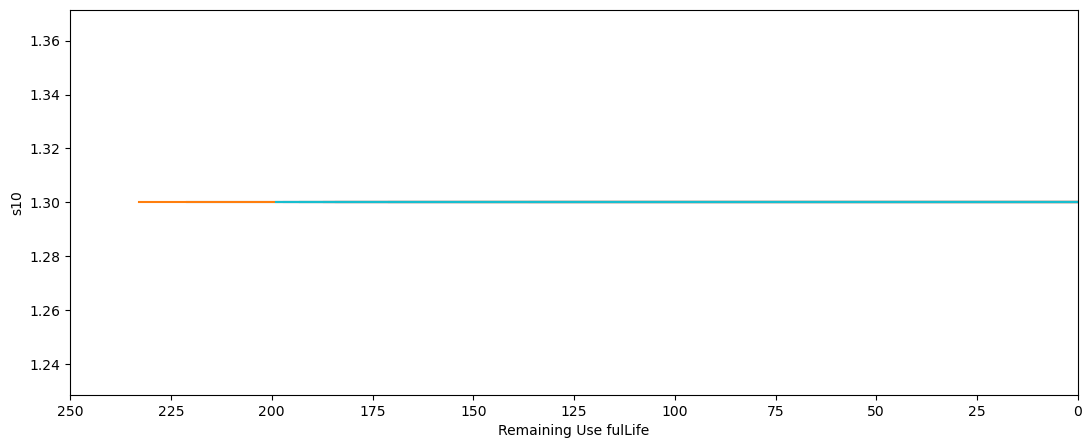

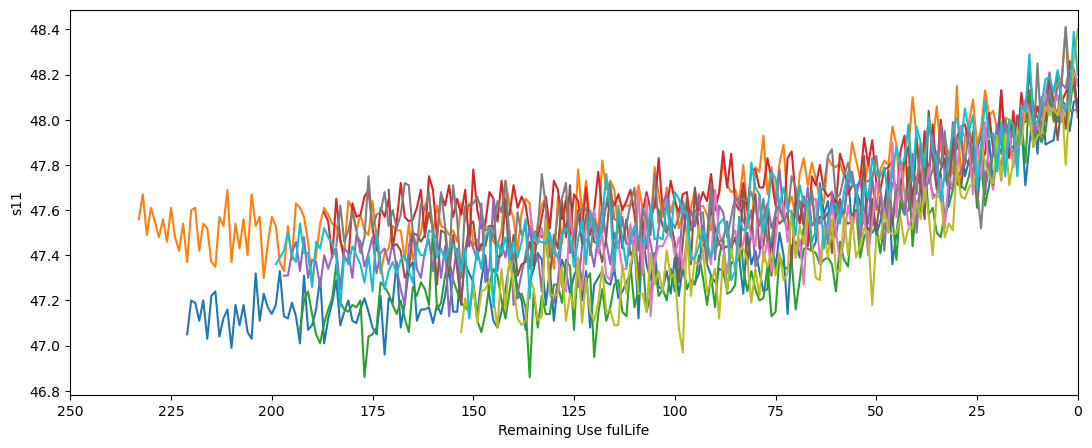

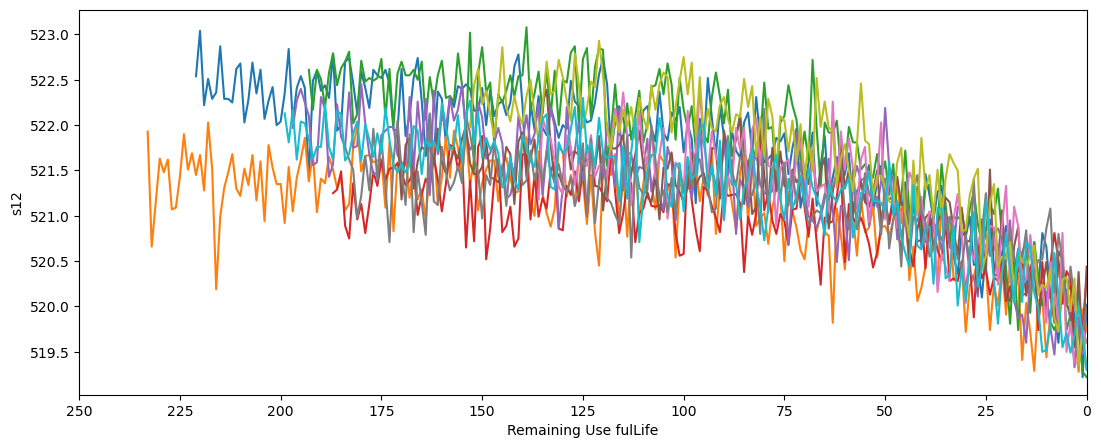

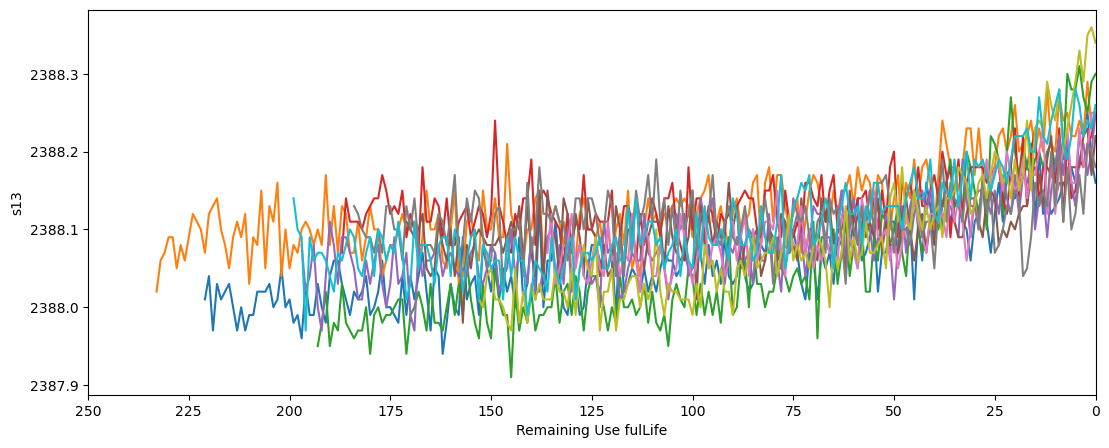

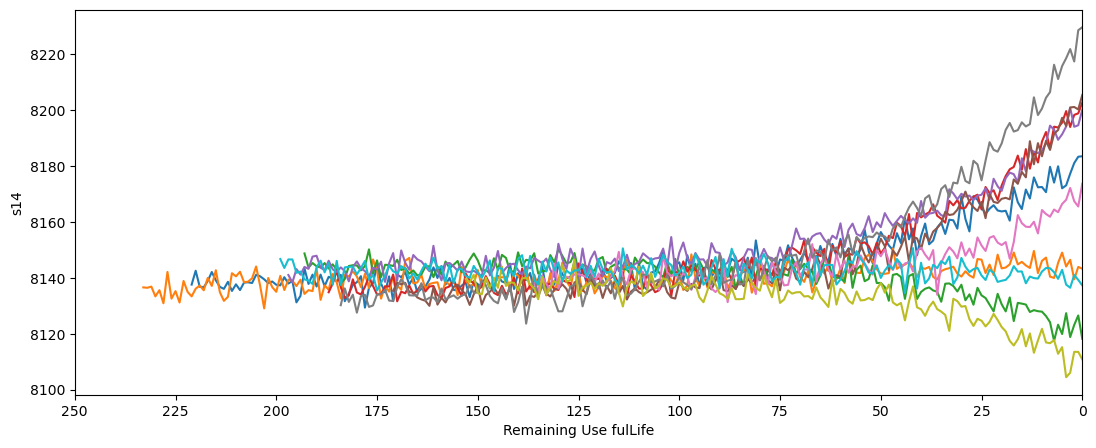

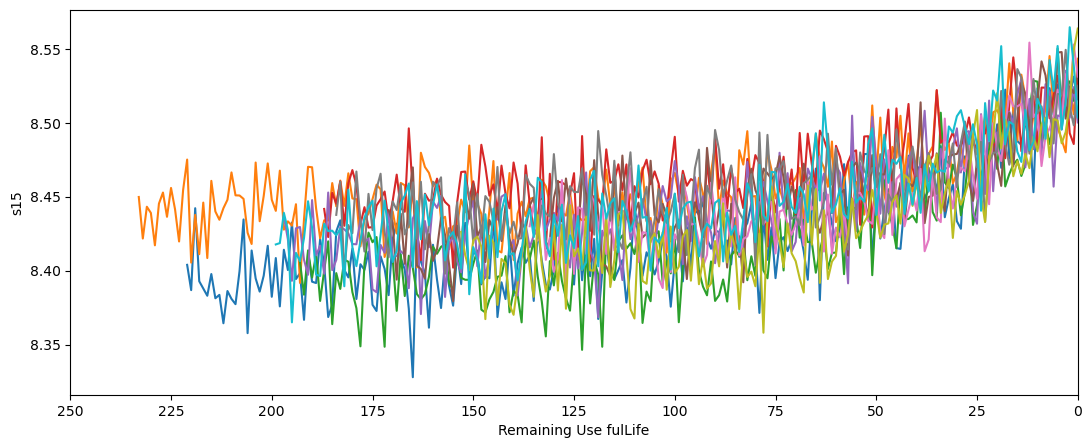

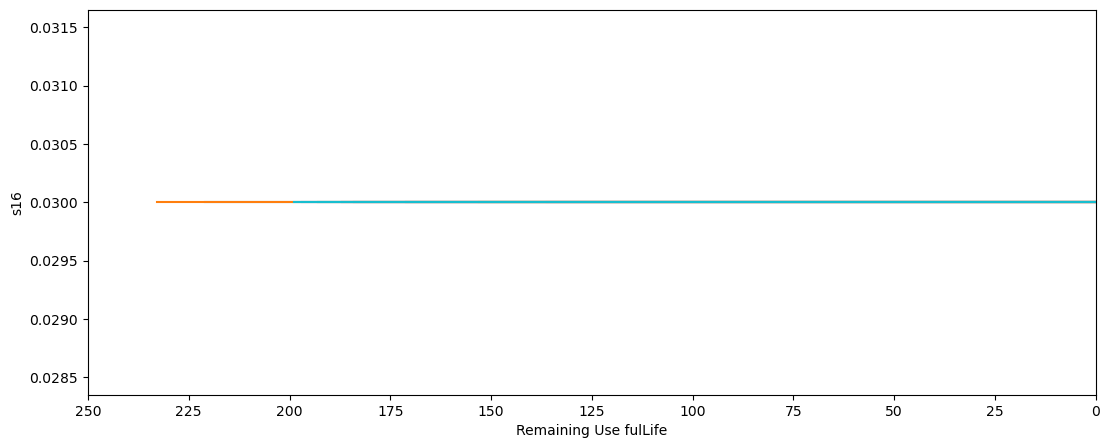

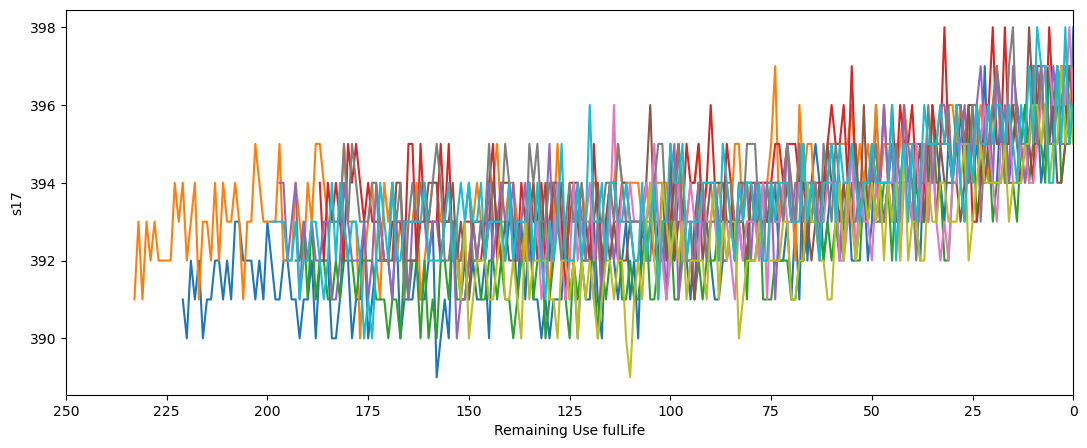

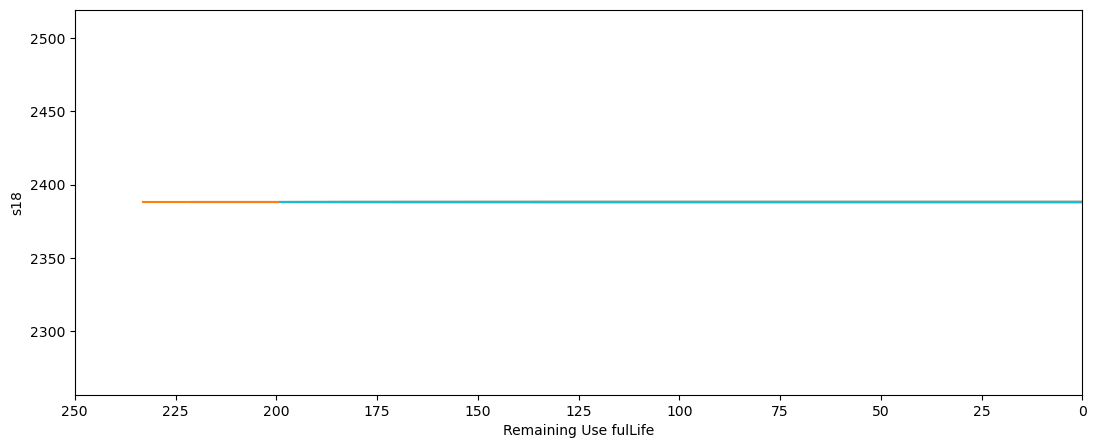

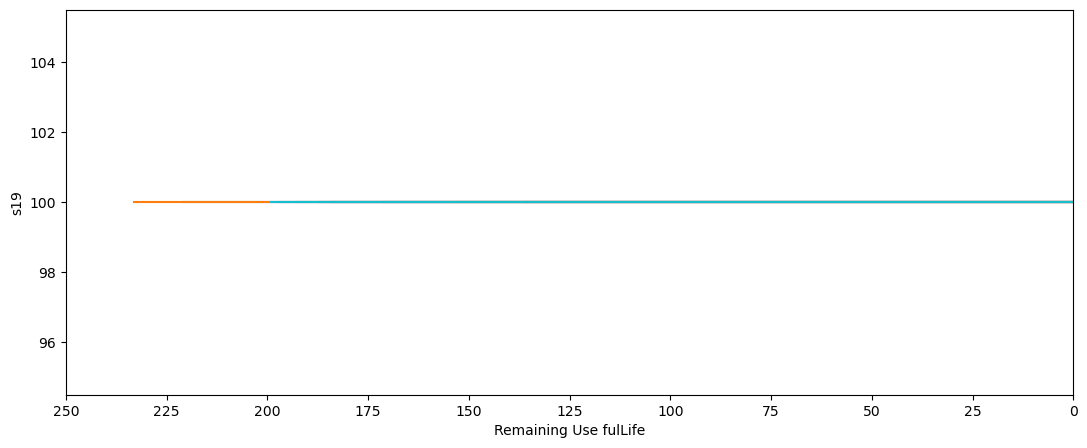

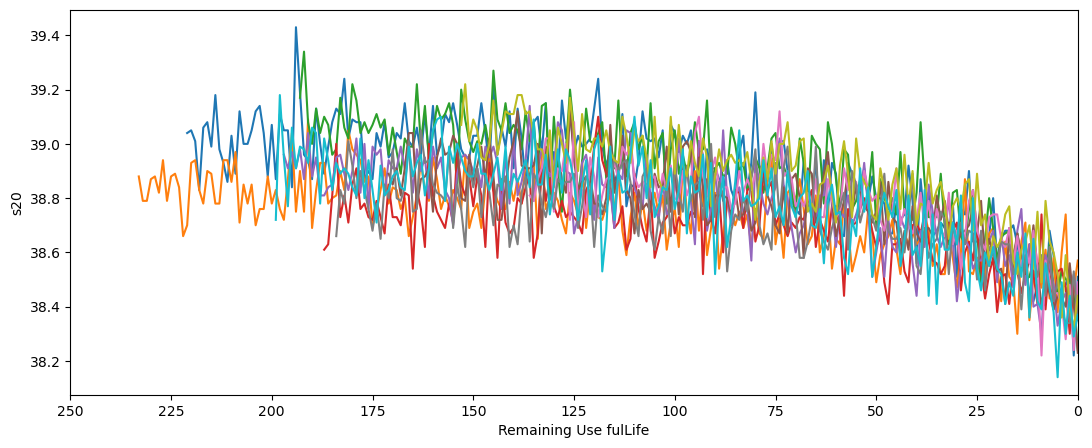

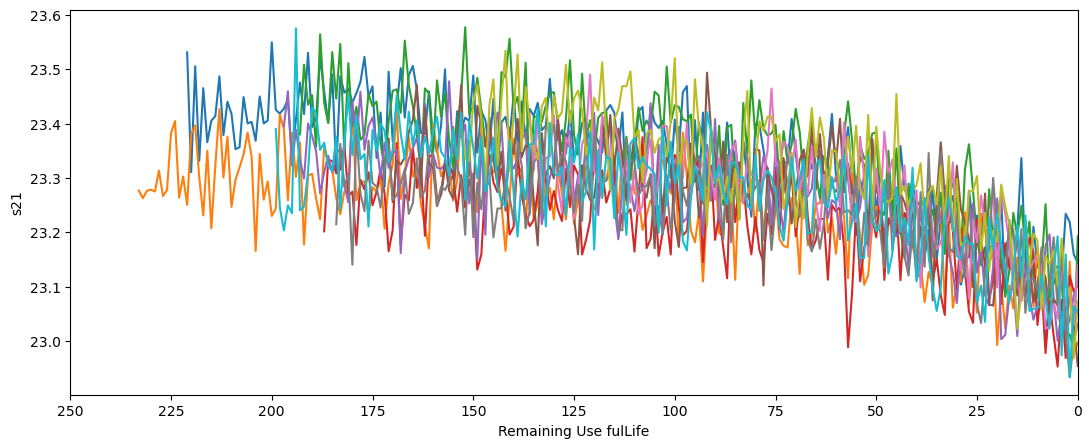

In [19]:
sensor_names1 = ["s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]
for s20 in sensor_names1:
    plot_sensor(s20)

In [20]:
# we make a new function which name is std_drop , this fu() is use to drop all the column which values of standard devation is less then threshold 0.0001.
threshold = 0.0001
def std_drop(df):
  df = df.drop(df.std()[abs(df.std()) < threshold].index.values, axis=1)
  df.head()
  return df

train_df=std_drop(train_df)
train_df.head()

unit  cycles  op_setting1  op_setting2      s2       s3       s4     s6  \
0     1       1      -0.0007      -0.0004  641.82  1589.70  1400.60  21.61   
1     1       2       0.0019      -0.0003  642.15  1591.82  1403.14  21.61   
2     1       3      -0.0043       0.0003  642.35  1587.99  1404.20  21.61   
3     1       4       0.0007       0.0000  642.35  1582.79  1401.87  21.61   
4     1       5      -0.0019      -0.0002  642.37  1582.85  1406.22  21.61   

       s7       s8       s9    s11     s12      s13      s14     s15  s17  \
0  554.36  2388.06  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392   
1  553.75  2388.04  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392   
2  554.26  2388.08  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390   
3  554.45  2388.11  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392   
4  554.00  2388.06  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393   

     s20      s21  rul  
0  39.06  23.4190  191  
1  39.00  23.4236  190  
2  38.95  23.3442  189  
3  38.88  23.3739  188  
4  38.90  23.4044  187

In [21]:
#we have call the fu() to do same thing with test_df, of droping column which values of std() is less then threshold.
test_df=std_drop(test_df)
test_df.head()

unit  cycles  op_setting1  op_setting2      s2       s3       s4     s6  \
0     1       1       0.0023       0.0003  643.02  1585.29  1398.21  21.61   
1     1       2      -0.0027      -0.0003  641.71  1588.45  1395.42  21.61   
2     1       3       0.0003       0.0001  642.46  1586.94  1401.34  21.61   
3     1       4       0.0042       0.0000  642.44  1584.12  1406.42  21.61   
4     1       5       0.0014       0.0000  642.51  1587.19  1401.92  21.61   

       s7       s8       s9    s11     s12      s13      s14     s15  s17  \
0  553.90  2388.04  9050.17  47.20  521.72  2388.03  8125.55  8.4052  392   
1  554.85  2388.01  9054.42  47.50  522.16  2388.06  8139.62  8.3803  393   
2  554.11  2388.05  9056.96  47.50  521.97  2388.03  8130.10  8.4441  393   
3  554.07  2388.03  9045.29  47.28  521.38  2388.05  8132.90  8.3917  391   
4  554.16  2388.01  9044.55  47.31  522.15  2388.03  8129.54  8.4031  390   

     s20      s21  rul  
0  38.86  23.3735   30  
1  39.02  23.3916   29  
2  39.08  23.4166   28  
3  39.00  23.3737   27  
4  38.99  23.4130   26

In [22]:
#we have make new function correlation, which is use to find the correlation between the all the column.
#then we make a set of all column, and use the 'for' loop to find the correlation between all column.
#then we make threshold of 0.9, we delete all those column which correlation grater then 0.9 .
#list(train_df.columns.values.tolist())
def correlation(databas, threshold):
  col_corr1 = set()
  corr_matrix1 = databas.corr()
  for i in range(len(corr_matrix1.columns)):#
      for j in range(i):#
        if i != j:#
          if (corr_matrix1.iloc[i, j] >= threshold) and (corr_matrix1.columns[j] not in col_corr1):#
            colname = corr_matrix1.columns[i] # getting the name of column#
            col_corr1.add(colname)#
            if colname in col_corr1:#
              print(colname)
              del databas[colname] # deleting the column from the dataset
  return databas
train_df=correlation(train_df,0.9)
train_df.head()

s14


unit  cycles  op_setting1  op_setting2      s2       s3       s4     s6  \
0     1       1      -0.0007      -0.0004  641.82  1589.70  1400.60  21.61   
1     1       2       0.0019      -0.0003  642.15  1591.82  1403.14  21.61   
2     1       3      -0.0043       0.0003  642.35  1587.99  1404.20  21.61   
3     1       4       0.0007       0.0000  642.35  1582.79  1401.87  21.61   
4     1       5      -0.0019      -0.0002  642.37  1582.85  1406.22  21.61   

       s7       s8       s9    s11     s12      s13     s15  s17    s20  \
0  554.36  2388.06  9046.19  47.47  521.66  2388.02  8.4195  392  39.06   
1  553.75  2388.04  9044.07  47.49  522.28  2388.07  8.4318  392  39.00   
2  554.26  2388.08  9052.94  47.27  522.42  2388.03  8.4178  390  38.95   
3  554.45  2388.11  9049.48  47.13  522.86  2388.08  8.3682  392  38.88   
4  554.00  2388.06  9055.15  47.28  522.19  2388.04  8.4294  393  38.90   

       s21  rul  
0  23.4190  191  
1  23.4236  190  
2  23.3442  189  
3  23.3739  188  
4  23.4044  187

In [23]:
#we use the same correlation function here for test_df
test_df=correlation(test_df,0.8)
test_df.head()

s14


unit  cycles  op_setting1  op_setting2      s2       s3       s4     s6  \
0     1       1       0.0023       0.0003  643.02  1585.29  1398.21  21.61   
1     1       2      -0.0027      -0.0003  641.71  1588.45  1395.42  21.61   
2     1       3       0.0003       0.0001  642.46  1586.94  1401.34  21.61   
3     1       4       0.0042       0.0000  642.44  1584.12  1406.42  21.61   
4     1       5       0.0014       0.0000  642.51  1587.19  1401.92  21.61   

       s7       s8       s9    s11     s12      s13     s15  s17    s20  \
0  553.90  2388.04  9050.17  47.20  521.72  2388.03  8.4052  392  38.86   
1  554.85  2388.01  9054.42  47.50  522.16  2388.06  8.3803  393  39.02   
2  554.11  2388.05  9056.96  47.50  521.97  2388.03  8.4441  393  39.08   
3  554.07  2388.03  9045.29  47.28  521.38  2388.05  8.3917  391  39.00   
4  554.16  2388.01  9044.55  47.31  522.15  2388.03  8.4031  390  38.99   

       s21  rul  
0  23.3735   30  
1  23.3916   29  
2  23.4166   28  
3  23.3737   27  
4  23.4130   26

In [24]:
# Normalise the data using Minmax scalar given in the sklearn preprocessing from cycles to RUL, RUL not included use slicing operation for both test and train
# Normalise both the train set and test set 
min_max_scaler = preprocessing.MinMaxScaler()
def scaleColumns(df, cols_to_scale):
     for col in cols_to_scale:
         df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
     return df
scaled_df = scaleColumns(train_df,[	"op_setting1",	"op_setting2",	"s2",	"s3",	"s4",	"s6",	"s7",	"s8",	"s9",	"s11",	"s12",	"s13",	"s15",	"s17",	"s20",	"s21"])
train_df

unit  cycles  op_setting1  op_setting2        s2        s3        s4  \
0         1       1     0.459770     0.166667  0.183735  0.406802  0.309757   
1         1       2     0.609195     0.250000  0.283133  0.453019  0.352633   
2         1       3     0.252874     0.750000  0.343373  0.369523  0.370527   
3         1       4     0.540230     0.500000  0.343373  0.256159  0.331195   
4         1       5     0.390805     0.333333  0.349398  0.257467  0.404625   
...     ...     ...          ...          ...       ...       ...       ...   
20626   100     196     0.477011     0.250000  0.686747  0.587312  0.782917   
20627   100     197     0.408046     0.083333  0.701807  0.729453  0.866475   
20628   100     198     0.522989     0.500000  0.665663  0.684979  0.775321   
20629   100     199     0.436782     0.750000  0.608434  0.746021  0.747468   
20630   100     200     0.316092     0.083333  0.795181  0.639634  0.842167   

        s6        s7        s8        s9       s11       s12       s13  \
0      1.0  0.726248  0.242424  0.109755  0.369048  0.633262  0.205882   
1      1.0  0.628019  0.212121  0.100242  0.380952  0.765458  0.279412   
2      1.0  0.710145  0.272727  0.140043  0.250000  0.795309  0.220588   
3      1.0  0.740741  0.318182  0.124518  0.166667  0.889126  0.294118   
4      1.0  0.668277  0.242424  0.149960  0.255952  0.746269  0.235294   
...    ...       ...       ...       ...       ...       ...       ...   
20626  1.0  0.254428  0.439394  0.196491  0.726190  0.170576  0.558824   
20627  1.0  0.162641  0.500000  0.194651  0.708333  0.211087  0.500000   
20628  1.0  0.175523  0.515152  0.198196  0.738095  0.281450  0.529412   
20629  1.0  0.133655  0.530303  0.233285  0.916667  0.208955  0.514706   
20630  1.0  0.151369  0.545455  0.178363  0.803571  0.130064  0.558824   

            s15       s17       s20       s21  rul  
0      0.363986  0.333333  0.713178  0.724662  191  
1      0.411312  0.333333  0.666667  0.731014  190  
2      0.357445  0.166667  0.627907  0.621375  189  
3      0.166603  0.333333  0.573643  0.662386  188  
4      0.402078  0.416667  0.589147  0.704502  187  
...         ...       ...       ...       ...  ...  
20626  0.656791  0.750000  0.271318  0.109500    4  
20627  0.727203  0.583333  0.124031  0.366197    3  
20628  0.922278  0.833333  0.232558  0.053991    2  
20629  0.823394  0.583333  0.116279  0.234466    1  
20630  0.687572  0.666667  0.178295  0.218172    0  

[20631 rows x 19 columns]

In [25]:
scaled_df = scaleColumns(test_df,["op_setting1",	"op_setting2",	"s2",	"s3",	"s4",	"s6",	"s7",	"s8",	"s9",	"s11",	"s12",	"s13",	"s15",	"s17",	"s20",	"s21"])
test_df

unit  cycles  op_setting1  op_setting2        s2        s3        s4  \
0         1       1      0.65625     0.692308  0.596215  0.421968  0.282214   
1         1       2      0.34375     0.230769  0.182965  0.504025  0.225240   
2         1       3      0.53125     0.538462  0.419558  0.464814  0.346130   
3         1       4      0.77500     0.461538  0.413249  0.391587  0.449867   
4         1       5      0.60000     0.461538  0.435331  0.471306  0.357974   
...     ...     ...          ...          ...       ...       ...       ...   
13091   100     194      0.81875     0.461538  0.665615  0.789665  0.641209   
13092   100     195      0.44375     0.384615  0.659306  0.692028  0.769042   
13093   100     196      0.47500     0.230769  0.728707  0.626071  0.458036   
13094   100     197      0.27500     0.538462  0.671924  0.673851  0.714111   
13095   100     198      0.59375     0.692308  0.574132  0.846014  0.829079   

        s6        s7        s8        s9       s11       s12       s13  \
0      1.0  0.608871  0.365854  0.196475  0.273973  0.534247  0.325581   
1      1.0  0.800403  0.292683  0.229042  0.479452  0.634703  0.395349   
2      1.0  0.651210  0.390244  0.248506  0.479452  0.591324  0.325581   
3      1.0  0.643145  0.341463  0.159080  0.328767  0.456621  0.372093   
4      1.0  0.661290  0.292683  0.153410  0.349315  0.632420  0.325581   
...    ...       ...       ...       ...       ...       ...       ...   
13091  1.0  0.510081  0.317073  0.902989  0.609589  0.299087  0.255814   
13092  1.0  0.471774  0.390244  0.890038  0.547945  0.381279  0.465116   
13093  1.0  0.435484  0.536585  0.937011  0.527397  0.410959  0.348837   
13094  1.0  0.502016  0.439024  0.952644  0.554795  0.445205  0.441860   
13095  1.0  0.322581  0.414634  1.000000  0.684932  0.385845  0.372093   

            s15    s17       s20       s21  rul  
0      0.347076  0.375  0.500000  0.620099   30  
1      0.227709  0.500  0.645455  0.645718   29  
2      0.533557  0.500  0.700000  0.681104   28  
3      0.282359  0.250  0.627273  0.620382   27  
4      0.337009  0.125  0.618182  0.676008   26  
...         ...    ...       ...       ...  ...  
13091  0.664909  0.625  0.309091  0.370842    4  
13092  0.567593  0.750  0.236364  0.483652    3  
13093  0.594919  0.750  0.281818  0.381741    2  
13094  0.662991  0.750  0.318182  0.473461    1  
13095  0.755034  0.875  0.354545  0.353999    0  

[13096 rows x 19 columns]

In [26]:
#we append new column TTF(time to faliure)
#This is the final preprocessing step TIME TO FALIURE T T F 
train_df['TTF'] = train_df['rul']
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())
fTTFz = []
fTTF = []

for i in range(train_df['unit'].min(),train_df['unit'].max()+1):
    dat=train_df[train_df.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
train_df['rul'] = fTTF
print(train_df.head())

   unit  cycles  op_setting1  op_setting2        s2        s3        s4   s6  \
0     1       1     0.459770     0.166667  0.183735  0.406802  0.309757  1.0   
1     1       2     0.609195     0.250000  0.283133  0.453019  0.352633  1.0   
2     1       3     0.252874     0.750000  0.343373  0.369523  0.370527  1.0   
3     1       4     0.540230     0.500000  0.343373  0.256159  0.331195  1.0   
4     1       5     0.390805     0.333333  0.349398  0.257467  0.404625  1.0   

         s7        s8        s9       s11       s12       s13       s15  \
0  0.726248  0.242424  0.109755  0.369048  0.633262  0.205882  0.363986   
1  0.628019  0.212121  0.100242  0.380952  0.765458  0.279412  0.411312   
2  0.710145  0.272727  0.140043  0.250000  0.795309  0.220588  0.357445   
3  0.740741  0.318182  0.124518  0.166667  0.889126  0.294118  0.166603   
4  0.668277  0.242424  0.149960  0.255952  0.746269  0.235294  0.402078   

        s17       s20       s21       rul  TTF  
0  0.333333  0.7131

In [27]:

print(len(train_df.columns))
print(len(test_df.columns))
train_df.head()

20
19


unit  cycles  op_setting1  op_setting2        s2        s3        s4   s6  \
0     1       1     0.459770     0.166667  0.183735  0.406802  0.309757  1.0   
1     1       2     0.609195     0.250000  0.283133  0.453019  0.352633  1.0   
2     1       3     0.252874     0.750000  0.343373  0.369523  0.370527  1.0   
3     1       4     0.540230     0.500000  0.343373  0.256159  0.331195  1.0   
4     1       5     0.390805     0.333333  0.349398  0.257467  0.404625  1.0   

         s7        s8        s9       s11       s12       s13       s15  \
0  0.726248  0.242424  0.109755  0.369048  0.633262  0.205882  0.363986   
1  0.628019  0.212121  0.100242  0.380952  0.765458  0.279412  0.411312   
2  0.710145  0.272727  0.140043  0.250000  0.795309  0.220588  0.357445   
3  0.740741  0.318182  0.124518  0.166667  0.889126  0.294118  0.166603   
4  0.668277  0.242424  0.149960  0.255952  0.746269  0.235294  0.402078   

        s17       s20       s21       rul  TTF  
0  0.333333  0.713178  0.724662  1.000000  191  
1  0.333333  0.666667  0.731014  0.994764  190  
2  0.166667  0.627907  0.621375  0.989529  189  
3  0.333333  0.573643  0.662386  0.984293  188  
4  0.416667  0.589147  0.704502  0.979058  187

In [28]:
#vectorize the data ,data converted in array
Train_X = train_df.values[:,1:18]
Train_Y = train_df.values[:,18]
Test_X = test_df.values[:,1:18]

In [29]:
Train_X

array([[1.00000000e+00, 4.59770115e-01, 1.66666667e-01, ...,
        3.33333333e-01, 7.13178295e-01, 7.24661696e-01],
       [2.00000000e+00, 6.09195402e-01, 2.50000000e-01, ...,
        3.33333333e-01, 6.66666667e-01, 7.31013532e-01],
       [3.00000000e+00, 2.52873563e-01, 7.50000000e-01, ...,
        1.66666667e-01, 6.27906977e-01, 6.21375311e-01],
       ...,
       [1.98000000e+02, 5.22988506e-01, 5.00000000e-01, ...,
        8.33333333e-01, 2.32558140e-01, 5.39906103e-02],
       [1.99000000e+02, 4.36781609e-01, 7.50000000e-01, ...,
        5.83333333e-01, 1.16279070e-01, 2.34465617e-01],
       [2.00000000e+02, 3.16091954e-01, 8.33333333e-02, ...,
        6.66666667e-01, 1.78294574e-01, 2.18171776e-01]])

life to death cycles =  100


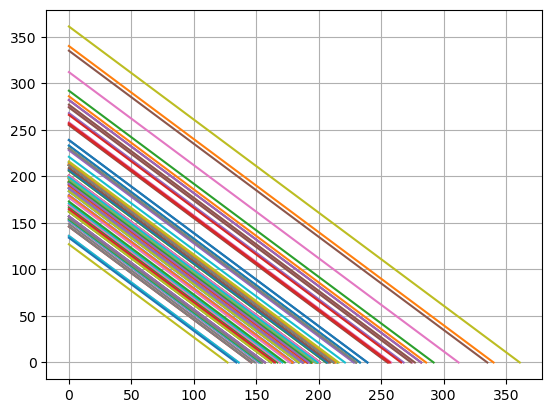

In [30]:
#How many life-to-death cycles do we have and what do they look like?
hom = len(train_df[train_df['TTF'] == 0])
print("life to death cycles = ",hom)
one_engine = []
for i,r in train_df.iterrows():
    rul = r['TTF']
    one_engine.append(rul)
    if rul == 0:
        plt.plot(one_engine)
        one_engine = []
        
plt.grid()

Artificial Neural Network

In [37]:
def  ANN():
    global tiger
    global score
    tiger = keras.Sequential([  
                          keras.layers.Dense(34,activation = 'relu',input_dim = 16), # 128,64,64,1
                          keras.layers.Dense(17,activation = 'relu'),
                          keras.layers.Dense(17,activation = 'relu'),
                          keras.layers.Dense(1)
        ])
    tiger.summary()

    tiger.compile(optimizer='sgd',
                loss='mean_squared_error',
                metrics=['accuracy'])

    tiger.fit(Train_X,Train_Y, epochs=10,validation_split=0.5)
    return tiger.predict(Test_X)

In [41]:
score = ANN()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 34)                578       
                                                                 
 dense_13 (Dense)            (None, 17)                595       
                                                                 
 dense_14 (Dense)            (None, 17)                306       
                                                                 
 dense_15 (Dense)            (None, 1)                 18        
                                                                 
Total params: 1,497
Trainable params: 1,497
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 24/323 [=>............................] - ETA: 1s - loss: 0.0967 - accuracy: 0.0052    

2023-02-20 20:33:39.274661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


323/323 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.0091

2023-02-20 20:33:40.798000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


323/323 [==============================] - 2s 7ms/step - loss: 0.0435 - accuracy: 0.0091 - val_loss: 0.0338 - val_accuracy: 0.0090
Epoch 2/10
323/323 [==============================] - 2s 7ms/step - loss: 0.0357 - accuracy: 0.0092 - val_loss: 0.0330 - val_accuracy: 0.0090
Epoch 3/10
323/323 [==============================] - 2s 7ms/step - loss: 0.0338 - accuracy: 0.0094 - val_loss: 0.0312 - val_accuracy: 0.0093
Epoch 4/10
323/323 [==============================] - 2s 7ms/step - loss: 0.0326 - accuracy: 0.0095 - val_loss: 0.0304 - val_accuracy: 0.0093
Epoch 5/10
323/323 [==============================] - 2s 7ms/step - loss: 0.0317 - accuracy: 0.0094 - val_loss: 0.0299 - val_accuracy: 0.0094
Epoch 6/10
323/323 [==============================] - 2s 7ms/step - loss: 0.0309 - accuracy: 0.0097 - val_loss: 0.0296 - val_accuracy: 0.0093
Epoch 7/10
323/323 [==============================] - 2s 7ms/step - loss: 0.0304 - accuracy: 0.0095 - val_loss: 0.0294 - val_accuracy: 0.0093
Epoch 8/10
323/32

2023-02-20 20:34:01.544421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


410/410 [==============================] - 1s 1ms/step


In [36]:
Train_X.shape

(20631, 17)

In [38]:
Train_X  = Train_X[:,1:17]
Test_X  = Test_X[:,1:17]


In [42]:
print(score.min(), score.max())
test_df = pd.merge(test_df, test_df.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
test_df.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
test_df['score'] = score

-0.18134776 0.92985344


In [ ]:
# Converting our 0-1 score to final cycles
def totcycles(data):
    return(data['cycles'] / (1-data['score']))
    
test_df['maxpredcycles'] = totcycles(test_df)

In [ ]:
# Converting the Cycles to remaining RUL
def RULfunction(data):
    return(data['maxpredcycles'] - data['maxcycles'])

test_df['RUL'] = RULfunction(test_df)